Correlation Matrix:
                avg_rating  avg_votes  avg_box_office
avg_rating        1.000000  -0.259565       -0.024418
avg_votes        -0.259565   1.000000        0.682402
avg_box_office   -0.024418   0.682402        1.000000


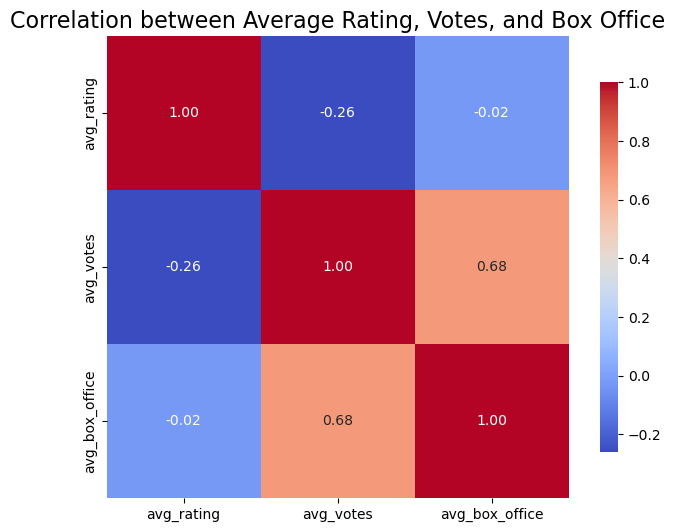

Top Genres by Average Box Office Earnings (Last 10 Years):
        Genre  avg_rating      avg_votes  avg_box_office
2   Animation    6.742105  137257.957895    1.397017e+08
1   Adventure    6.499600  266824.980000    1.327446e+08
8      Family    6.545455   59713.272727    6.007196e+07
0      Action    6.333971  151265.784689    4.677430e+07
15     Sci-Fi    6.198667  177581.866667    4.548199e+07
5       Crime    6.549153  138295.000000    3.391803e+07


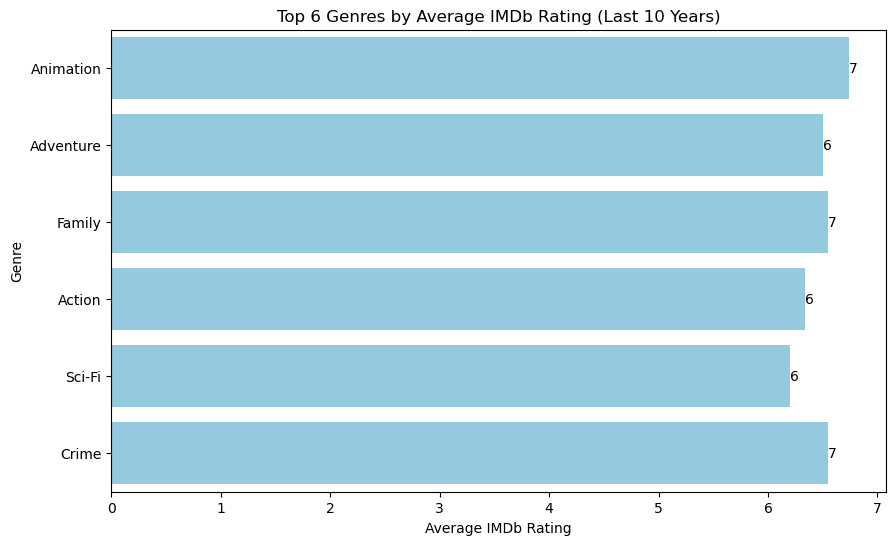

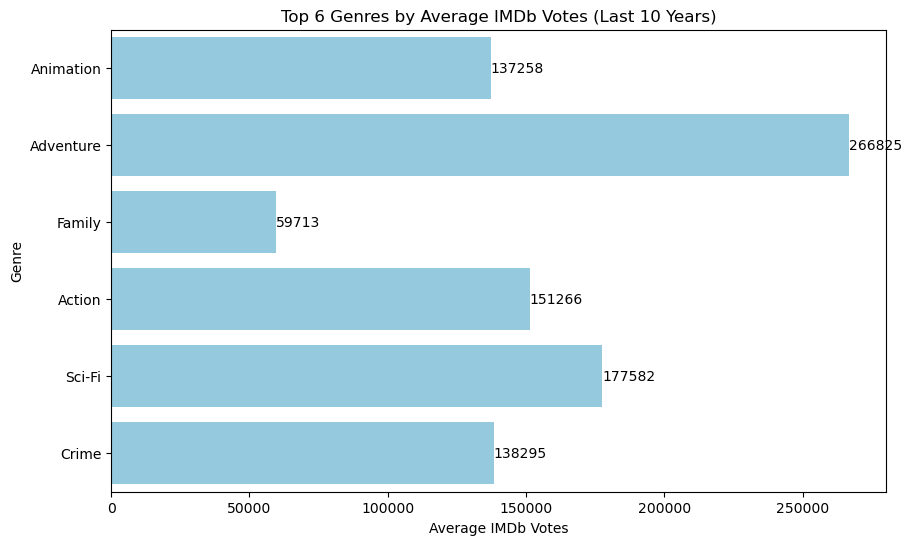

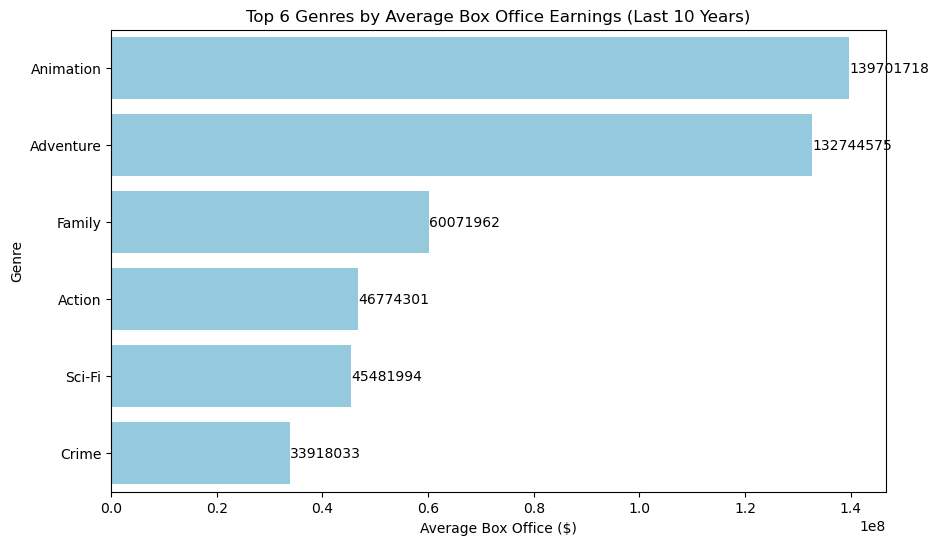

Correlation Matrix:
                       normalized_box_office  normalized_rating  \
normalized_box_office               1.000000           0.101481   
normalized_rating                   0.101481           1.000000   
normalized_votes                    0.872208           0.158251   

                       normalized_votes  
normalized_box_office          0.872208  
normalized_rating              0.158251  
normalized_votes               1.000000  


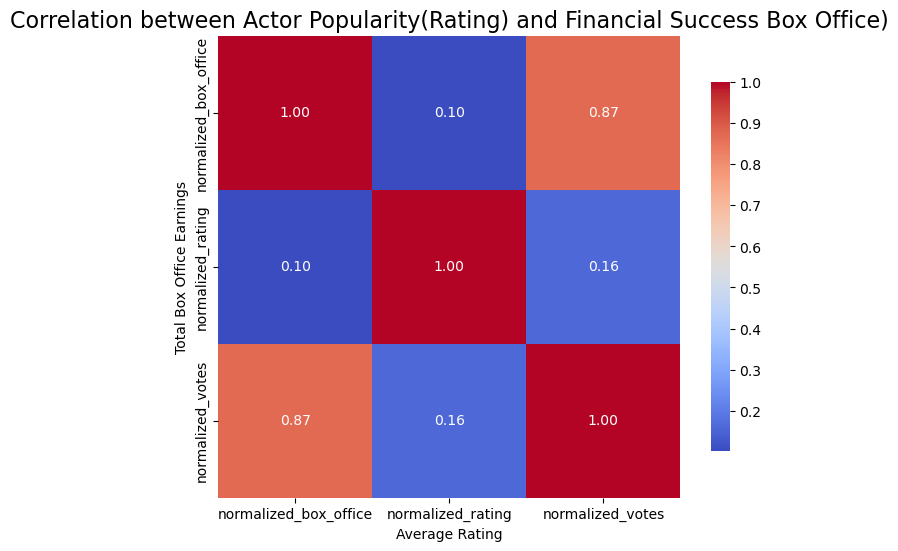


Average BoxOffice by Runtime Category:
Runtime_Category
120-150 min    7.686788e+07
150-180 min    9.603365e+07
180-210 min    1.285707e+08
90-120 min     4.106020e+07
< 90 min       3.472526e+07
> 210 min      3.288634e+07
Name: BoxOffice, dtype: float64


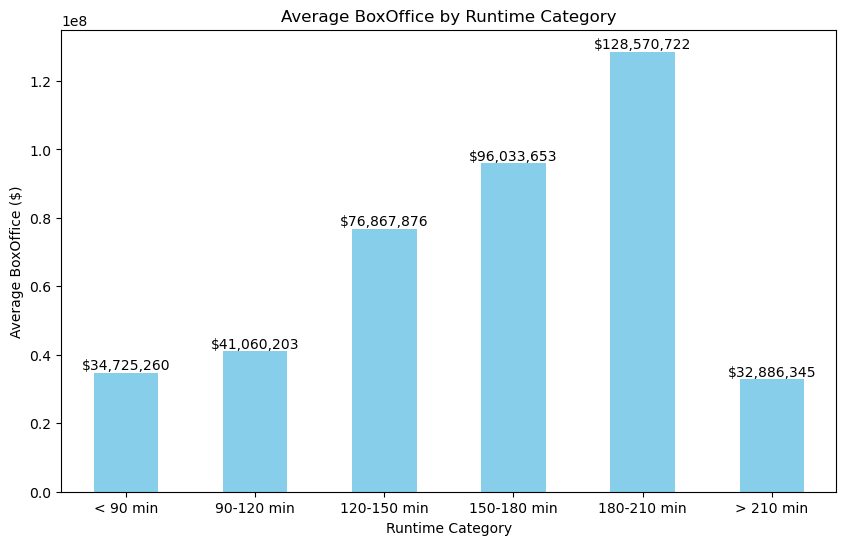

In [14]:
import pandas as pd
import requests
import time
import csv
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

#Read data file
url = '/Users/rishikeshdhokare/Downloads/MergedDataSet/Final/final_omdb_data_no_duplicates.csv'
df = pd.read_csv(url)

############################################# Hypothesis 1 ##########################################################

df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
recent_years_df = df[df['Year'] >= (df['Year'].max() - 10)]

recent_years_df = recent_years_df.assign(Genre=recent_years_df['Genre'].str.split(',')).explode('Genre')
recent_years_df['Genre'] = recent_years_df['Genre'].str.strip()  

recent_years_df['BoxOffice'] = pd.to_numeric(recent_years_df['BoxOffice'].replace(r'[\$,]', '', regex=True), errors='coerce')
recent_years_df['imdbVotes'] = pd.to_numeric(recent_years_df['imdbVotes'].replace(',', '', regex=True), errors='coerce')

# Calculate average metrics
genre_statistics_recent_df = recent_years_df.groupby('Genre').agg(
    avg_rating=('imdbRating', 'mean'),      
    avg_votes=('imdbVotes', 'mean'),        
    avg_box_office=('BoxOffice', 'mean')
).reset_index()

# Correlation between Rating, Votes, and Box Office
correlation_matrix = genre_statistics_recent_df[['avg_rating', 'avg_votes', 'avg_box_office']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation between Average Rating, Votes, and Box Office', fontsize=16)
plt.show()


# Sort genres by average box office earnings
genre_sorted_by_box_office = genre_statistics_recent_df.sort_values(by='avg_box_office', ascending=False).head(6)
print("Top Genres by Average Box Office Earnings (Last 10 Years):")
print(genre_sorted_by_box_office)

# Bar chart for average rating by Genre
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_rating', y='Genre', data=genre_sorted_by_box_office, color='skyblue')
plt.xlabel('Average IMDb Rating')
plt.ylabel('Genre')
plt.title('Top 6 Genres by Average IMDb Rating (Last 10 Years)')
for index, value in enumerate(genre_sorted_by_box_office['avg_rating']):
    plt.text(value, index, f'{value:.0f}', va='center')
plt.show()

# Bar chart for average votes by Genre
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_votes', y='Genre', data=genre_sorted_by_box_office, color='skyblue')
plt.xlabel('Average IMDb Votes')
plt.ylabel('Genre')
plt.title('Top 6 Genres by Average IMDb Votes (Last 10 Years)')
for index, value in enumerate(genre_sorted_by_box_office['avg_votes']):
    plt.text(value, index, f'{value:.0f}', va='center')
plt.show()

# Bar chart for average box office earnings by Genre
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_box_office', y='Genre', data=genre_sorted_by_box_office, color='skyblue')
plt.xlabel('Average Box Office ($)')
plt.ylabel('Genre')
plt.title('Top 6 Genres by Average Box Office Earnings (Last 10 Years)')
for index, value in enumerate(genre_sorted_by_box_office['avg_box_office']):
    plt.text(value, index, f'{value:.0f}', va='center')
plt.show()

############################################# Hypothesis 2 ##########################################################

df['Lead_Actor'] = df['Actor'].str.split(',').str[0]  
df['Lead_Actor'] = df['Lead_Actor'].str.strip()

# Convert BoxOffice and imdbVotes to numeric
df['BoxOffice'] = pd.to_numeric(df['BoxOffice'].replace(r'[\$,]', '', regex=True), errors='coerce')
df['imdbVotes'] = pd.to_numeric(df['imdbVotes'].replace(',', '', regex=True), errors='coerce')

#Group by Lead Actor
lead_actor_statistics_df = df.groupby('Lead_Actor').agg(
    num_movies=('Title', 'count'),          
    avg_rating=('imdbRating', 'mean'),      
    total_votes=('imdbVotes', 'sum'),        
    total_box_office=('BoxOffice', 'sum')   
).reset_index()

#avg_rating: Will be scaled between 0 and 1 (relative to the min and max rating values).
#total_votes: Will be scaled between 0 and 1 based on the min and max votes.
#total_box_office: Will be scaled between 0 and 1 based on the min and max box office values.
# Normalize metrics using MinMaxScaler

scaler = MinMaxScaler()

lead_actor_statistics_df.dropna(subset=['avg_rating', 'total_votes', 'total_box_office'], inplace=True)

lead_actor_statistics_df[['normalized_rating', 'normalized_votes', 'normalized_box_office']] = scaler.fit_transform(
    lead_actor_statistics_df[['avg_rating', 'total_votes', 'total_box_office']]
)

# Correlation analysis
correlation_matrix = lead_actor_statistics_df[['normalized_box_office', 'normalized_rating', 'normalized_votes']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Scatter plot for normalized box office vs. normalized rating
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.xlabel('Average Rating')
plt.ylabel('Total Box Office Earnings')
plt.title('Correlation between Actor Popularity(Rating) and Financial Success Box Office)', fontsize=16)
plt.show()

############################################# Hypothesis 3 ##########################################################
#Hypothesis 3
df['BoxOffice'] = df['BoxOffice'].replace({r'\$': '', r',': ''}, regex=True)
df['BoxOffice'] = pd.to_numeric(df['BoxOffice'], errors='coerce')

df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')

def classify_runtime(runtime):
    if pd.isna(runtime):
        return 'Unknown'
    if runtime < 90:
        return '< 90 min'
    elif 90 <= runtime < 120:
        return '90-120 min'
    elif 120 <= runtime < 150:
        return '120-150 min'
    elif 150 <= runtime < 180:
        return '150-180 min'
    elif 180 <= runtime < 210:
        return '180-210 min'
    else:
        return '> 210 min'

df['Runtime_Category'] = df['Runtime'].apply(classify_runtime)
runtime_boxoffice_avg = df.groupby('Runtime_Category')['BoxOffice'].mean()
print("\nAverage BoxOffice by Runtime Category:")
print(runtime_boxoffice_avg)

categories = ['< 90 min','90-120 min','120-150 min', '150-180 min', '180-210 min', '> 210 min']
for category in categories:
    if category not in runtime_boxoffice_avg:
        runtime_boxoffice_avg[category] = None

# Order runtime categories
runtime_boxoffice_avg = runtime_boxoffice_avg.reindex(['< 90 min', '90-120 min', '120-150 min', 
                                                      '150-180 min', '180-210 min', '> 210 min'])

# Graph
plt.figure(figsize=(10, 6))
runtime_boxoffice_avg.plot(kind='bar', color=['skyblue'])
plt.title('Average BoxOffice by Runtime Category')
plt.xlabel('Runtime Category')
plt.ylabel('Average BoxOffice ($)')
plt.xticks(rotation=0)

# Adding text annotations for the bar values
for i in range(len(runtime_boxoffice_avg)):
    plt.text(i, runtime_boxoffice_avg.iloc[i], 
             f"${runtime_boxoffice_avg.iloc[i]:,.0f}" if pd.notna(runtime_boxoffice_avg.iloc[i]) else 'N/A', 
             ha='center', va='bottom')

plt.show()
